# [1] Car Classification

In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
%matplotlib inline

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel0_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel1_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel0_hist[0], channel1_hist[0], channel2_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Training

In [2]:
 
# Read in cars and notcars
# images = glob.glob('*.jpeg')
cars = []
notcars = []

nonCarImgs = glob.glob('../non-vehicles/*/*.png')
for image in nonCarImgs:
    notcars.append(image)
    
carImgs = glob.glob('../vehicles/*/*.png')
for image in carImgs:
    cars.append(image)

In [3]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 2000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]


### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 720] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
25.7 Seconds to train SVC...
Test Accuracy of SVC =  0.978


## Sharing HOG

In [4]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def search_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
#     scale = 1   # magnification of window based on 64*64pixels, e.g. 2->2x->128*128pixels, 0.5->0.5x->32*32pixels

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = img.astype(np.float32)/255

    img_tosearch = image[ystart:ystop,:,:]
    # ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = img_tosearch    #assuming imported image is in RGB
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch0 = ctrans_tosearch[:,:,0]
    ch1 = ctrans_tosearch[:,:,1]
    ch2 = ctrans_tosearch[:,:,2]

    # Compute individual channel HOG features for the entire image
    hog0 = get_hog_features(ch0, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)

    # size of search area (in pixels)
    xspan = ch0.shape[1]
    yspan = ch0.shape[0]

    # due to all training sets are 64x64pixels images
    pixels_per_window = 64
    window_overlay = 0.75   # 75% overlay
    # number of windows on each dimension
    nx_windows_per_span = int((xspan - pixels_per_window*window_overlay)/(pixels_per_window*(1-window_overlay)))
    ny_windows_per_span = int((yspan - pixels_per_window*window_overlay)/(pixels_per_window*(1-window_overlay)))

    # given HOG block step = 1 cell
    # n_cells_per_blockstep = 1
    n_cells_per_window = int(pixels_per_window / pix_per_cell)
    n_blocksteps_per_window = int((n_cells_per_window-cell_per_block+1)/1)
    n_cells_per_window_step = int((pixels_per_window-pixels_per_window*window_overlay) / pix_per_cell)
    n_blocksteps_per_window_step = int((n_cells_per_window_step-cell_per_block+1)/1)

    boxes = []
    for ixWindow in range(nx_windows_per_span):
        for iyWindow in range(ny_windows_per_span):
            nx_blocksteps_window_left = ixWindow*n_cells_per_window_step
            ny_blocksteps_window_top = iyWindow*n_cells_per_window_step
            subhog0 = hog0[ny_blocksteps_window_top:ny_blocksteps_window_top+n_blocksteps_per_window,
                           nx_blocksteps_window_left:nx_blocksteps_window_left+n_blocksteps_per_window]
            subhog1 = hog1[ny_blocksteps_window_top:ny_blocksteps_window_top+n_blocksteps_per_window,
                           nx_blocksteps_window_left:nx_blocksteps_window_left+n_blocksteps_per_window]
            subhog2 = hog2[ny_blocksteps_window_top:ny_blocksteps_window_top+n_blocksteps_per_window,
                           nx_blocksteps_window_left:nx_blocksteps_window_left+n_blocksteps_per_window]
            hog_features = np.concatenate((subhog0.ravel(), subhog1.ravel(), subhog2.ravel()))
    #         print(hog_features.shape)
            pixels_window_left = nx_blocksteps_window_left * pix_per_cell
            pixels_window_top = ny_blocksteps_window_top * pix_per_cell
            subimg = ctrans_tosearch[pixels_window_top:pixels_window_top+pixels_per_window,
                                    pixels_window_left:pixels_window_left+pixels_per_window]
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
    #         print(subimg.shape)

            # Scale features and make a prediction
    #         test_features = X_scaler.transform(np.concatenate((spatial_features, hist_features, hog_features),0))
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xleft = np.int(pixels_window_left*scale)
                ytop = np.int(pixels_window_top*scale)
                win = np.int(pixels_per_window*scale)
                boxes.append(((xleft, ytop+ystart),(xleft+win, ytop+ystart+win)))

    return boxes
    

C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


19.47 Seconds ...


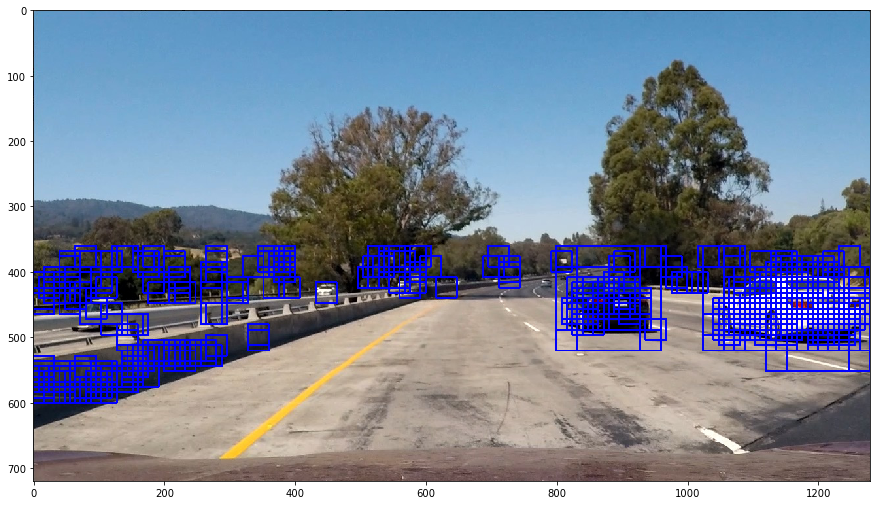

In [6]:
# image = mpimg.imread(r'..\test_images\bbox-example-image.jpg')
image = mpimg.imread(r'..\test_images\test1.jpg')
draw_image = np.copy(image)

t = time.time()
boxes32 = search_cars(image, 360, 600, 0.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
boxes64 = search_cars(image, 360, 720, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
boxes128 = search_cars(image, 360, 720, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

t2 = time.time()
print(round(t2-t, 2), 'Seconds ...')

plt.figure(figsize=(15,10))
plt.imshow(draw_boxes(image, boxes32+boxes64+boxes128, thick=2))
plt.savefig('carClassify3264128.png',dpi=300)

In [7]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [8]:
heat_map_seq = []
heat_thresh = 10
from scipy.ndimage.measurements import label

def car_classify(img):
    boxes32 = search_cars(img, 360, 600, 0.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes64 = search_cars(img, 360, 720, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes128 = search_cars(img, 360, 720, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    map0 = np.zeros((720,1280))
    heat_map_seq.append(add_heat(map0, boxes32+boxes64+boxes128))
    heat_window = min(9, len(heat_map_seq))
    print(heat_window)
    if heat_window==1:
        heat_map = apply_threshold(np.sum(heat_map_seq,0), heat_thresh*heat_window)
    else:
        heat_map = apply_threshold(np.sum(heat_map_seq[len(heat_map_seq)-heat_window:len(heat_map_seq)],0), 
                                   heat_thresh*heat_window)
    labels = label(heat_map)
    if labels[1]>0:
        return draw_labeled_bboxes(img, labels)
    else:
        return img

C:\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1


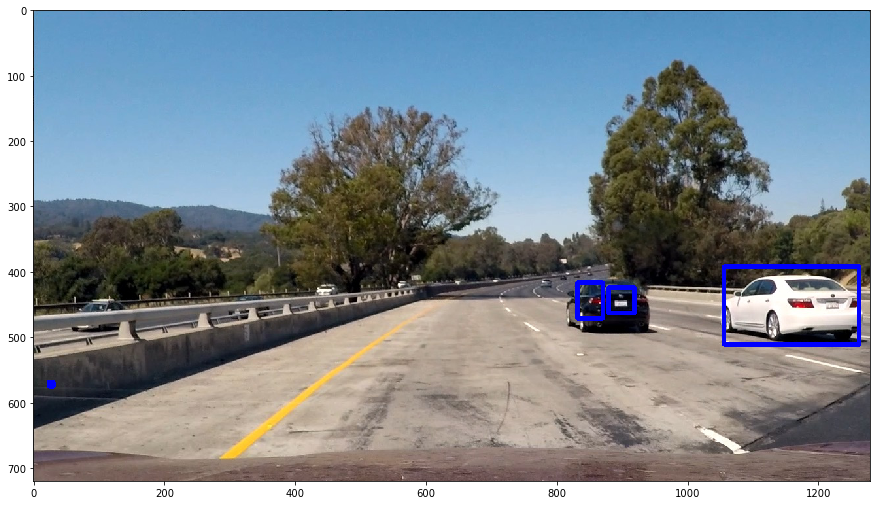

In [11]:
heat_map_seq = []
heat_thresh = 10
image = mpimg.imread(r'..\test_images\test1.jpg')
plt.figure(figsize=(15,10))
plt.imshow(car_classify(image))
plt.savefig('carClassifyHotWin.png', dpi=300)

# [2] Lane Finding

In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from scipy.stats import norm
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
%matplotlib inline



In [10]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
imgShapes = []

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    imgShapes.append(img.shape)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [11]:
# In this project, image shape at numpy is (720, 1280, 3)
# There are 720 rows, 1280 cols, and each pixel contains 3 color elements.
imgShape = np.mean(imgShapes, 0).astype(int)
# Image size for cv2 is (1280, 720)
img_size = (imgShape[1], imgShape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


In [12]:
def HLS_S_select(img, thresh=(0,255)):
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = HLS[:,:,2]
    binary_out = np.zeros_like(S)
    binary_out[(S>=thresh[0])&(S<thresh[1])]=1
    return binary_out

def RGB_R_select(img, thresh=(0,255)):
    R = img[:,:,0]
    binary_out = np.zeros_like(R)
    binary_out[(R>=thresh[0])&(R<thresh[1])]=1
    return binary_out

def window_mask(width, height, img, center,level):
    output = np.zeros_like(img)
    output[max(0,int(img.shape[0]-(level+1)*height)):max(0,int(img.shape[0]-level*height)),
           max(0,int(center-width/2)):min(int(center+width/2),img.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_w_sigma, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
#     window = np.ones(window_width) # Create our window template that we will use for convolutions
    # Plot between -10 and 10 with .001 steps.
    x_axis = np.arange(-window_width/2, window_width/2, 1)
    # Mean = 0, SD = 10.
    window = norm.pdf(x_axis,0,window_w_sigma)
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum half bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(warped.shape[0]/2):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum,'same')) #convolve with same padding
    r_sum = np.sum(warped[int(warped.shape[0]/2):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum,'same'))+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
#     window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range((int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[(warped.shape[0]-(level+1)*window_height):(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer, 'same')
        # Find the best left centroid by using past left center as a reference
        l_min_index = int(max(l_center-margin,0))
        l_max_index = int(min(l_center+margin,warped.shape[1]-1))
        l_density = np.sum(image_layer[l_min_index:l_max_index]) / (l_max_index-l_min_index)
        l_BG= (np.sum(image_layer[0:l_min_index])+np.sum(image_layer[l_max_index:(int)((l_center+r_center)/2)]))
        l_BG_density = l_BG /(l_min_index-0+(int)((l_center-0+r_center)/2)-l_max_index)
        if l_density>l_BG_density:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center-margin,0))
        r_max_index = int(min(r_center+margin,warped.shape[1]-1))
        r_density = np.sum(image_layer[r_min_index:r_max_index]) / (r_max_index-r_min_index)
        r_BG = (np.sum(image_layer[(int)((l_center+r_center)/2):r_min_index])+np.sum(image_layer[l_max_index:warped.shape[1]-1]))
        r_BG_density = r_BG / (r_min_index-(int)((l_center+r_center)/2)+warped.shape[1]-1-l_max_index)
        if r_density>r_BG_density:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def ImageOverlay(img1, img2):
    img2IsZero = (img2==0)
    return img1*img2IsZero + img2

In [13]:
all_good_l_lane_x = []
all_good_l_lane_y = []
all_good_r_lane_x = []
all_good_r_lane_y = []
def FindLaneAndDraw(img, mtx, dist, imgShape, aglx, agly, agrx, agry):
    img_undistort = cv2.undistort(img, mtx, dist, None, mtx)


    S_binary = HLS_S_select(img, thresh=(100,256))
    R_binary = RGB_R_select(img, thresh=(200,256))

    combine_binary = (S_binary & R_binary) 

    pIni = np.float32([[217,720], [566,470], [720,470], [1113,720]])
    pFin = np.float32([[1.0/4*imgShape[1],imgShape[0]],[1.0/4*imgShape[1],1.0/3*imgShape[0]],
                       [3.0/4*imgShape[1],1.0/3*imgShape[0]],[3.0/4*imgShape[1],imgShape[0]]])
    M = cv2.getPerspectiveTransform(pIni, pFin)
    Minv = cv2.getPerspectiveTransform(pFin, pIni)
    img_warped = cv2.warpPerspective(combine_binary, M, img_size, flags=cv2.INTER_LINEAR)

    if len(img_warped.shape)==3:
        warped = cv2.cvtColor(img_warped, cv2.COLOR_RGB2GRAY)
    else:
        warped = img_warped*255
    # window settings
    window_width = 300
    window_w_sigma = 50
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = window_width/2 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_w_sigma, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_lane_mask = np.zeros_like(warped)
        r_lane_mask = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_lane_mask[l_mask == 1] = 255
            r_lane_mask[r_mask == 1] = 255

        l_lane = warped & l_lane_mask
        r_lane = warped & r_lane_mask
    # If no window centers found, just display orginal road image
    else:
        l_lane_mask = np.zeros_like(warped)
        r_lane_mask = np.zeros_like(warped)
        l_lane = warped & l_lane_mask
        r_lane = warped & r_lane_mask

    #left/right lanes pixels MvAvg #frames
    lane_pixels_MvSum_frames = 10
    l_lane_nonzero = l_lane.nonzero()
    if len(l_lane_nonzero[1])>0:
        aglx.append(l_lane_nonzero[1]) 
        agly.append(l_lane_nonzero[0])
    else: #this will cause duplicated data hence affecting MvAvg, but can prevent un-sync of left/right lane sampling times
        aglx.append(aglx[-1])
        agly.append(agly[-1])
    if len(aglx)>lane_pixels_MvSum_frames:
        l_lane_x = np.concatenate(aglx[len(aglx)-lane_pixels_MvSum_frames:-1])
        l_lane_y = np.concatenate(agly[len(agly)-lane_pixels_MvSum_frames:-1])
    else:
        l_lane_x = np.concatenate(aglx[:])
        l_lane_y = np.concatenate(agly[:])

    r_lane_nonzero = r_lane.nonzero()
    if len(r_lane_nonzero[1])>0:
        agrx.append(r_lane_nonzero[1]) 
        agry.append(r_lane_nonzero[0])  
    else:
        agrx.append(agrx[-1])
        agry.append(agry[-1])
    if len(agrx)>lane_pixels_MvSum_frames:
        r_lane_x = np.concatenate(agrx[len(agrx)-lane_pixels_MvSum_frames:-1])
        r_lane_y = np.concatenate(agry[len(agry)-lane_pixels_MvSum_frames:-1])
    else:
        r_lane_x = np.concatenate(agrx[:])
        r_lane_y = np.concatenate(agry[:])


    l_fit = np.polyfit(l_lane_y, l_lane_x, 2)
    r_fit = np.polyfit(r_lane_y, r_lane_x, 2)
    l_fit_weight = len(l_lane_y)
    r_fit_weight = len(r_lane_y)
    l_interp = np.poly1d(l_fit)
    r_interp = np.poly1d(r_fit)

    ys = np.linspace(0, imgShape[0]-1, imgShape[0])

    lane_width_pixels = imgShape[1]/2
    dash_length_pixels = 90
    lane_width_meters = 3.7
    dash_length_meters = 3
    x_pixel2meter = lane_width_meters/lane_width_pixels
    y_pixel2meter = dash_length_meters/dash_length_pixels

    ys_meter = ys*y_pixel2meter

    l_lane_x_meter = l_lane_x * x_pixel2meter
    l_lane_y_meter = l_lane_y * y_pixel2meter

    r_lane_x_meter = r_lane_x * x_pixel2meter
    r_lane_y_meter = r_lane_y * y_pixel2meter

    l_fit_meter = np.polyfit(l_lane_y_meter, l_lane_x_meter, 2)
    r_fit_meter = np.polyfit(r_lane_y_meter, r_lane_x_meter, 2)
    l_interp_meter = np.poly1d(l_fit_meter)
    r_interp_meter = np.poly1d(r_fit_meter)

    # Curvature radius
    y_max_meter = np.max(ys_meter)
    l_curvR_meter = ((1 + (2*l_fit_meter[0]*y_max_meter + l_fit_meter[1])**2)**1.5) / np.absolute(2*l_fit_meter[0])
    r_curvR_meter = ((1 + (2*r_fit_meter[0]*y_max_meter + r_fit_meter[1])**2)**1.5) / np.absolute(2*r_fit_meter[0])
    print(l_curvR_meter, r_curvR_meter)

    # offset position to lane center
    vehicle_offset_meter = imgShape[1]/2*x_pixel2meter - (l_interp_meter(y_max_meter)+r_interp_meter(y_max_meter))/2 


    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_l_lane = np.array(np.transpose(np.stack((l_interp(ys), ys),0)))
    pts_r_lane = np.array(np.flipud(np.transpose(np.stack((r_interp(ys), ys),0))))
    pts = np.concatenate((pts_l_lane, pts_r_lane),0)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size, flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undistort, 1, newwarp, 0.3, 0)

    #add on screen texts describing current driving condition calculations
    onScreenTextImage = Image.new("RGB", (1280,720), (0,0,0))
    draw = ImageDraw.Draw(onScreenTextImage)
    colorText = (255,0,0)
    fontLarge = ImageFont.truetype("arial.ttf", 50)
    fontSmall = ImageFont.truetype("arial.ttf", 30)
    avg_curvR_meter = (l_curvR_meter*l_fit_weight+r_curvR_meter*r_fit_weight) / (l_fit_weight+r_fit_weight)
    draw.text((50,50), 'Lane Curvature Radius = {:.1f} km'.format(avg_curvR_meter/1000),  colorText, font=fontLarge) 
    draw.text((50,100), 'Vehicle Offset from Lane Center = {:.1f} m'.format(vehicle_offset_meter), colorText, font=fontLarge) 
    draw.text((50,150),'left_fit = '+str(l_fit),  colorText, font=fontSmall) 
    draw.text((50,180),'right_fit = '+str(r_fit),  colorText, font=fontSmall)  
    onScreenText = np.array(onScreenTextImage.getdata()).reshape(onScreenTextImage.size[1], onScreenTextImage.size[0], 3).astype('uint8')

    return ImageOverlay(result, onScreenText)


644.000581746 408.161254778


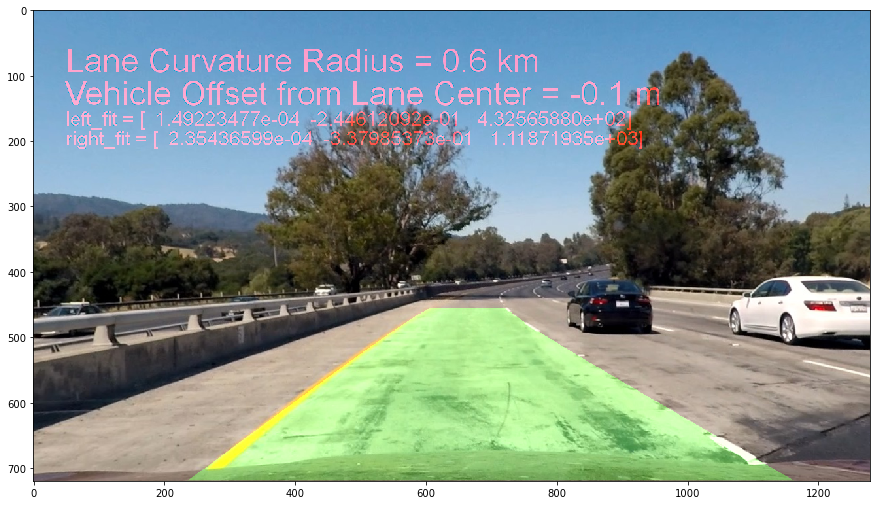

In [14]:
# Read raw image to be undistorted
# imgFile = r'..\test_images\straight_lines2.jpg'
imgFile = r'..\test_images\test1.jpg'
img = mpimg.imread(imgFile)

plt.figure(figsize=(15,15))
rst = FindLaneAndDraw(img, mtx, dist, imgShape, 
                    all_good_l_lane_x, all_good_l_lane_y, all_good_r_lane_x, all_good_r_lane_y)
plt.imshow(rst)
plt.savefig('laneFind.png',dpi=300)

# [3] Car Classify + Lane Finding on video

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
# all_good_l_lane_x = []
# all_good_l_lane_y = []
# all_good_r_lane_x = []
# all_good_r_lane_y = []
# heat_map_seq = []
# heat_thresh = 10

# def CarClassifyAndLaneFind(image):
#     img = car_classify(image);
#     return FindLaneAndDraw(img, mtx, dist, imgShape, 
#                         all_good_l_lane_x, all_good_l_lane_y, all_good_r_lane_x, all_good_r_lane_y);

In [ ]:
heat_map_seq = []
heat_thresh = 10
from scipy.ndimage.measurements import label
all_good_l_lane_x = []
all_good_l_lane_y = []
all_good_r_lane_x = []
all_good_r_lane_y = []


def CarClassifyAndLaneFind(img):

    boxes32 = search_cars(img, 360, 600, 0.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes64 = search_cars(img, 360, 720, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes128 = search_cars(img, 360, 720, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    map0 = np.zeros((720,1280))
    heat_map_seq.append(add_heat(map0, boxes32+boxes64+boxes128))
    heat_window = min(9, len(heat_map_seq))
    print(heat_window)
    if heat_window==1:
        heat_map = apply_threshold(np.sum(heat_map_seq,0), heat_thresh*heat_window)
    else:
        heat_map = apply_threshold(np.sum(heat_map_seq[len(heat_map_seq)-heat_window:len(heat_map_seq)],0), 
                                   heat_thresh*heat_window)
    labels = label(heat_map)
    
    image = FindLaneAndDraw(img, mtx, dist, imgShape, 
                        all_good_l_lane_x, all_good_l_lane_y, all_good_r_lane_x, all_good_r_lane_y);
    
    if labels[1]>0:
        return draw_labeled_bboxes(image, labels)
    else:
        return image

In [ ]:
white_output = '../ProjectVideoOutv5.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4").subclip(39,40)
white_clip = clip1.fl_image(CarClassifyAndLaneFind) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

1
30040.0478071 707.844257927
[MoviePy] >>>> Building video ../ProjectVideoOutv5.mp4
[MoviePy] Writing video ../ProjectVideoOutv5.mp4


  0%|                                                              | 0/26 [00:00<?, ?it/s]

2
30040.0478072 707.844257927


  4%|██                                                    | 1/26 [00:08<03:24,  8.19s/it]

3
18989.5525646 782.537816244


  8%|████▏                                                 | 2/26 [00:16<03:17,  8.25s/it]

4
24300.7126747 604.465703064


 12%|██████▏                                               | 3/26 [00:24<03:09,  8.22s/it]

5
85211.3463441 507.10762296


 15%|████████▎                                             | 4/26 [00:32<03:00,  8.19s/it]

6
30372.2766629 454.209987178


 19%|██████████▍                                           | 5/26 [00:40<02:51,  8.17s/it]

7
12275.9703652 437.008425174


 23%|████████████▍                                         | 6/26 [00:48<02:40,  8.02s/it]

8
15558.1098837 440.160169317


 27%|██████████████▌                                       | 7/26 [00:58<02:43,  8.63s/it]

9
7693.30196827 432.90039225


 31%|████████████████▌                                     | 8/26 [01:06<02:32,  8.50s/it]

9
3091.80672626 441.921931711


 35%|██████████████████▋                                   | 9/26 [01:14<02:21,  8.31s/it]

9
3552.32622784 454.411480573


 38%|████████████████████▍                                | 10/26 [01:23<02:16,  8.51s/it]

9
2958.28339064 444.139216652


 42%|██████████████████████▍                              | 11/26 [01:31<02:06,  8.43s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
labels